# Adjusting Miner Scoring in the Bittensor Subnet: a difficulty based incentive

## Introduction  

In this notebook, we aim to lay the groundwork for implementing the reward function in this Bittensor subnet. At its core, the optimisation goal is to minimise the average error between the miner's prediction and the actual measured environmental values. To ensure positive and negative errors don't cancel out, an intuitive measure would be to minimise the Root Mean Squared Error (RMSE). However, this metric does not take into account the actual difficulty of the problem, which is why a **weighted-RMSE**-reward is introduced in this notebook.

### The Reward Function  

The reward function we use to evaluate miner performance is defined as:  

$$
\text{RMSE(m)} = \sqrt{\frac{1}{N}\sum_{i=1}^N \left(f(x_i) - y_i\right)^2}
$$
$$
\overline{\text{RMSE(m)}} = \frac{\text{Max}_n(\text{RMSE(n)}) - \text{RMSE(m)}}{\text{Max}_n(\text{RMSE}(n)) - \text{Min}_n(\text{RMSE}(n))}
$$
$$
\gamma = \text{pow}(\text{scaler}, {(\overline{z} * 2 - 1)})
$$
$$
\text{Reward} = \text{pow}(\overline{\text{RMSE(m)}}, \; {\gamma})
$$

Where:  
- $N$: The total number of data points (both in time and location) the sample has.
- $f(x_i)$: The miner's prediction for time-location point $x_i$  
- $y_i$: The true prediction at time-location $x_i$ 
- RMSE($m$): The root mean squared error of miner $m$
- $\overline{z}$: the averaged normalised (i.e. between 0 and 1) difficulty score as we have precalculated for every possible region.
- $\gamma$: the exponent used for gamma-correction, based on a configurable scaler.

This relative scoring approach ensures that miners are consistently incentivized to improve their predictions in comparison to their peers, regardless of the absolute difficulty of the prediction task. However, the difficult correction using $\gamma$ ensures the difficulty is accurately taken into account. 

### Why do we need $z$ values?

The $z$ value, or *difficulty* value is crucial because it sets the threshold for acceptable error that is time and location based. A higher $z$ makes the task easier by allowing more error, while a lower $z$ makes it harder by narrowing the acceptable margin for error.  Depending on the geographical location of the data sampled, the difficulty of the problem can vary substantially. A region in the middle of the pacific ocean boasts very minor differences in for example temperature, meaning a simple average would already obtain very low RMSE scores. Alternatively, a region full of mountains is difficult even for the best models, and we do not want to penalise miners purely based on which geographical location they have been sent. For that reason, we invented a difficulty based incentive based on the natural variation of temperature for each time and location.

### How to calculate $z$ values?
The main idea behind our calculation is that the historical rate of fluctuation is a good indicator for the difficulty of a certain geographical location. Note that the amount of change per hour itself is not that important: if this rate is constant, predictions are still relatively simple. We will therefore look at the variance of this rate of change, so the variance of the derivative over time for each location. We will calculate this variance for each location separately on a per-month basis, which means there are between 672-744 hourly measurements, large enough for the variance to be a meaningful indicator. By doing so monthly as opposed to yearly, we can guarantee that seasonal effects/larger trends do not influence our calculation, which is desired since we are only interested in the unpredictability. 

This notebook calculates 721x1440 matrices of $z$ scores for each location. It saves a separate matrix for each month, based on the latest available year of ERA5 data (2023-10 until 2024-10). These files are also stored in this GitHub and can be used for validation right away.


This reward function ensures a fair, data-driven approach to incentivizing accurate climate forecasting in the Bittensor subnet.

In [ ]:
import requests
import xarray as xr
import torch
import os
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
dataset = xr.open_zarr("gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3", chunks=None)
dataset = dataset[["2m_temperature"]]
dataset = dataset.sel(time=slice("2023-10-31", "2024-10-31"))

# convert latitude and longitude to -90 to 90 and -180 to 180 respectively
if dataset["longitude"].max() > 180:
     dataset = dataset.assign_coords(longitude=(dataset["longitude"].values + 180) % 360 - 180)
if dataset["latitude"].max() > 90:
    dataset = dataset.assign_coords(latitude=dataset["latitude"].values - 90)

dataset = dataset.sortby(["latitude", "longitude"])
dataset = dataset.chunk()

### How much data will we download?

In [12]:
dataset["2m_temperature"]

<xarray.DataArray '2m_temperature' (time: 1323648, latitude: 721,
                                    longitude: 1440)> Size: 5TB
dask.array<xarray-2m_temperature, shape=(1323648, 721, 1440), dtype=float32, chunksize=(1323648, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * time       (time) datetime64[ns] 11MB 1900-01-01 ... 2050-12-31T23:00:00
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K

### Download and create difficulty file per month

In [8]:
MONTHS = ["2023-10", "2023-11", "2023-12", "2024-01", "2024-02", "2024-03", "2024-04", "2024-05", "2024-06", "2024-07", "2024-08", "2024-09", "2024-10"]
WRITE_FILES = False

In [ ]:
absolute_max = 0
stored_difficulties = []
for i, start in enumerate(MONTHS[:-1]):
    end = MONTHS[i+1]
    month_data = dataset.sel(time=slice(start, end))

    # fetch that data -- takes 1-2 minutes per call
    month_data = month_data.compute()

    # calculate the 'variance of time-derivative' for each location
    t2m_data = torch.as_tensor(month_data["2m_temperature"].data, dtype=torch.float)
    t2m_diffs = torch.diff(t2m_data, n=1, dim=0)
    var_per_loc = t2m_diffs.var(dim=0)

    month_str = start.split('-')[-1]
    print(f"Min/Mean/Max for {month_str}", var_per_loc.min(), var_per_loc.mean(), var_per_loc.max())

    if var_per_loc.max() > absolute_max:
        absolute_max = var_per_loc.max()
    
    stored_difficulties.append((month_str, var_per_loc.numpy()))

    
if WRITE_FILES:
    for month_str, var_per_loc in stored_difficulties:
        var_per_loc = var_per_loc / absolute_max
        np.save(f"../data/weights/difficulty_{month_str}_grid_025.npy", var_per_loc.numpy())

Min/Mean/Max for 10 tensor(0.0029) tensor(0.3871) tensor(8.6252)
Min/Mean/Max for 11 tensor(0.0032) tensor(0.3710) tensor(8.4370)
Min/Mean/Max for 12 tensor(0.0033) tensor(0.3663) tensor(8.2429)
Min/Mean/Max for 01 tensor(0.0037) tensor(0.3951) tensor(8.0224)
Min/Mean/Max for 02 tensor(0.0048) tensor(0.4386) tensor(7.6828)
Min/Mean/Max for 03 tensor(0.0041) tensor(0.4665) tensor(7.2004)
Min/Mean/Max for 04 tensor(0.0035) tensor(0.4832) tensor(6.0816)
Min/Mean/Max for 05 tensor(0.0031) tensor(0.4951) tensor(6.6980)
Min/Mean/Max for 06 tensor(0.0031) tensor(0.4873) tensor(7.3180)
Min/Mean/Max for 07 tensor(0.0028) tensor(0.4746) tensor(8.2530)
Min/Mean/Max for 08 tensor(0.0028) tensor(0.4618) tensor(6.9014)
Min/Mean/Max for 09 tensor(0.0026) tensor(0.4332) tensor(6.3587)


### Plot and inspect the last difficulty map

In [22]:
# create artificial grid of latitudes and longitudes for plotting
x_grid = torch.stack(
    torch.meshgrid(
        *[
            torch.as_tensor(
                dataset[v].data, dtype=torch.float
            )
            for v in ("latitude", "longitude")
        ],
        indexing="ij",
    ),
    dim=-1,
)

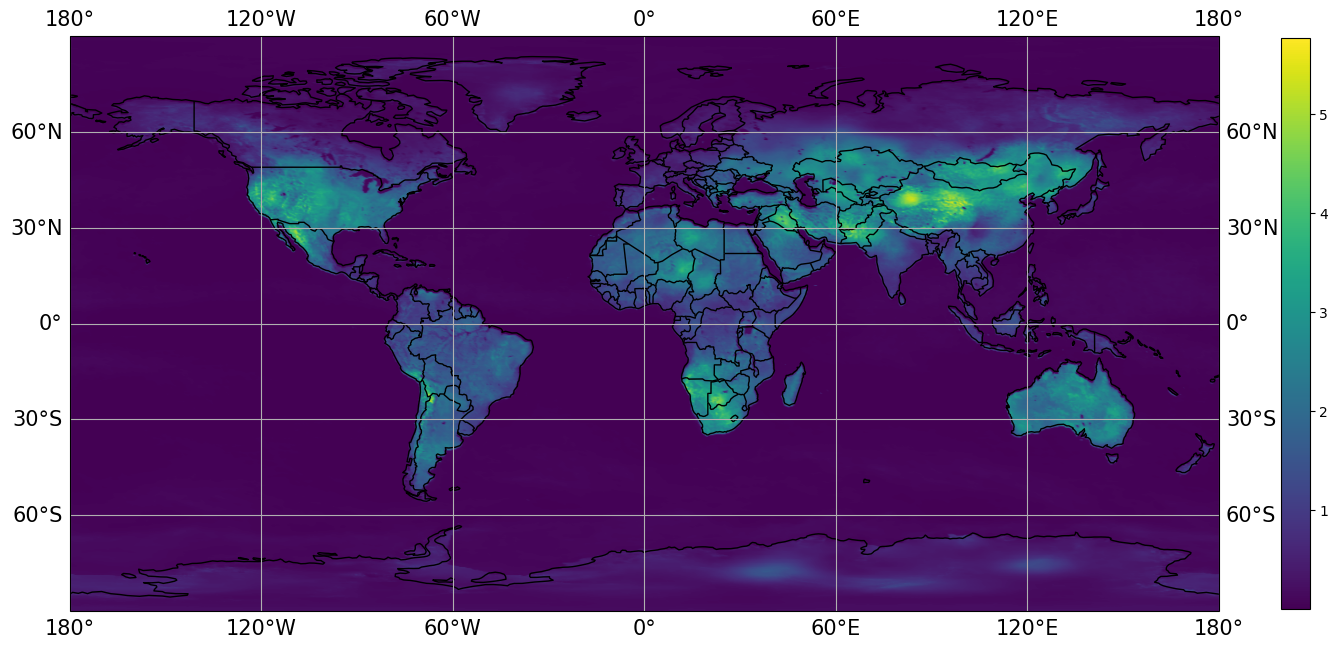

In [ ]:
# plot the last month's data
fig = plt.figure(figsize=(16.0, 12.0), dpi=100)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.set_axisbelow(True)

gl = ax.gridlines(draw_labels=True)
gl.xlabel_style = {"size": 15}
gl.ylabel_style = {"size": 15}
scatterplot = ax.scatter(
        x_grid[..., -1], 
        x_grid[..., -2], 
        c=var_per_loc, 
        s= 10,
        marker= "o",
        lw= 0, 
)

cbar = fig.colorbar(scatterplot, ax=ax, fraction=0.023, pad=0.05)
plt.show()